In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
FILENAME="td_percentage_definition"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="do3se_phenology"
DEPENDENCIES=[
    ("thermal_time", "github.com/SEI-DO3SE/thermal_time.git"),
    ("do3se_phenology", "github.com/SEI-DO3SE/do3se_phenology.git"),
    ("do3se_met", "github.com/SEI-DO3SE/do3se_met.git"),
    ("notebook_utils", "github.com/sbland/notebook_utils.git"),
]

In [3]:
# UNCOMMENT IF USING COLAB
# # Add colab link
# from IPython.display import Markdown as md
# md(f"""
# <a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/master/notebooks/{FILENAME}.ipynb" target="_parent">
#     <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
# </a>
# """)


<a href="https://colab.research.google.com/github/SEI-DO3SE/do3se_phenology/blob/master/notebooks/td_percentage_definition.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [4]:
# # UNCOMMENT IF USING COLAB
# # Colab setup
# #@title Download libraries from github
# #@markdown Code Hidden
# try:
#     import importlib
#     for name, path in DEPENDENCIES:
#         importlib.import_module(name)
# except (ImportError, ModuleNotFoundError):
#     if 'google.colab' in str(get_ipython()):
#         print('Running on CoLab')
#         print("""
#         This notebook requires access to private repositories. To access follow the steps below:
#         1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
#         2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
#         """)
#         from google.colab import drive
#         drive.mount('/content/drive')

#         !mkdir -p ~/.access
#         !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
#         import os
#         creds = open(f'{os.path.expanduser("~")}/.access/config')
#         creds_parsed = creds.read().splitlines()
#         user, token = creds_parsed
#         for name, path in DEPENDENCIES:
#             !pip install git+https://{user}:{token}@{path}
#         creds.close()
#         creds = None
#         creds_parsed = None

In [44]:
from itertools import accumulate
from notebook_utils.widgets import *

In [4]:
from do3se_met.irradiance import *
from thermal_time.calcs import *

In [5]:
%load_ext autoreload
%autoreload 2

from do3se_phenology.phyllochron_dvi import *
from do3se_phenology.td_percent_definition import *
from do3se_phenology.f_phen import *
from do3se_phenology.plots import *


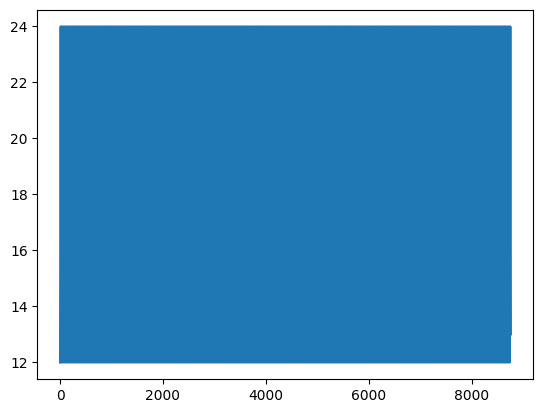

In [6]:
# Demo data
day_count = 365
lat = 20

dd_data = np.array([[d for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
hrs_data = np.array([[i for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
demo_temp_data = [24-abs(hr-12) for hr in hrs_data]
accumulated_temperatures = list(accumulate(demo_temp_data))

plt.plot(demo_temp_data)
 


In [7]:
# Calc thermal time and photoperiod
T_b, T_o, T_m = [0,20,50]
lat = 50
p_crit=24
p_sens=0
tsc = demo_temp_data
td = calc_thermal_time_range(tsc, t_b=T_b)
teff = [calc_effective_temperature(sum(tsc[d*24:(d+1)*24]),T_b, T_o, T_m) for d in dd_data]
photoperiod = [calc_photoperiod(dd, lat) for dd in dd_data]
rpe = [calc_rpe(p_crit=p_crit, p_sens=p_sens, p=P) for P in photoperiod]

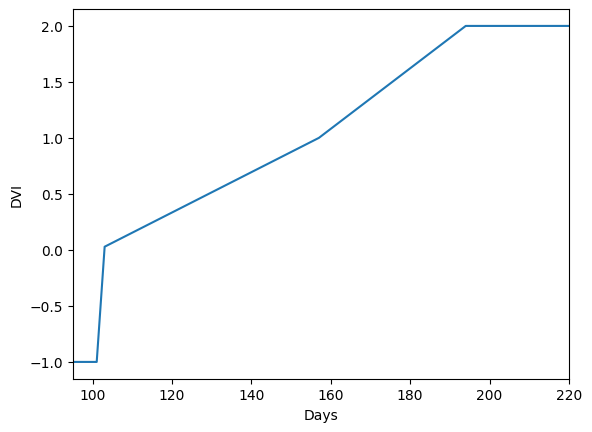

In [8]:
# Calc DVI

dvi = [-1]
tt_emr, tt_veg, tt_rep = [35, 1000, 666]
sowing_day = 100
for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
  if hr == 0:
    new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
    dvi.append(new_dvi)
plt.xlim(sowing_day - 5, sowing_day+120)
plt.plot(dvi)
plt.xlabel("Days")
plt.ylabel("DVI")
plt.show()

In [9]:
emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])


# Interactive

## DVI

In [10]:
#@title Life stage from td_data
@interact_plus_reset(
  tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
  tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
  tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
  sowing_day = widgets.FloatSlider(min=1, max=365, value=100, step=1),   
)
def run(tt_emr, tt_veg, tt_rep, sowing_day):
  dvi = [-1]
  for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
    if hr == 0:
      new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
      dvi.append(new_dvi)
  plt.xlim(sowing_day - 5, sowing_day+120)
  plt.plot(dvi)
  plt.xlabel("Days")
  plt.ylabel("DVI")

  emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
  phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])
  life_stages = calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=0.3)
  life_stages
  plt.show()


Button(description='Reset', style=ButtonStyle())

Output()

## Get thermal days


In [11]:
    (
        SGS,
        EGS,
        Astart,
        mid_anthesis,
        fphen_a,
        fphen_b,
        fphen_c,
        fphen_d,
        dd_emr,
        dd_veg,
        dd_rep,
        t_Astart,
        t_mid_anthesis,
        t_fphen_a,
        t_fphen_b,
        t_fphen_c,
        t_fphen_d,
        tt_emr,
        tt_veg,
        tt_rep,
    ) = get_canopy_td_intervals(
        td,
        dd_data,
        t_sgs=100,
        t_egs=1850,
    )

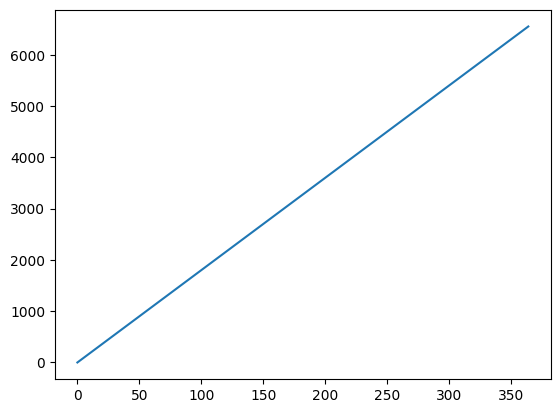

In [12]:
td_daily = [td for td, hr in zip(td, hrs_data) if hr == 0]
plt.plot(td_daily)

In [13]:
#@title leaf_f_phen
@interact_plus_reset(
  tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
  tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
  tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
  t_astart=widgets.FloatSlider(min=1, max=2000, value=950, step=1),
  td_at_sgs=widgets.FloatSlider(min=1, max=2000, value=100, step=1),
)
def get_t_l(
    tt_emr, tt_veg, tt_rep,
    t_astart,
    td_at_sgs,
):
    # DVI
    fig, axs = plt.subplots(ncols=2)
    dvi = [-1]
    for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
        if hr == 0:
            new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
            dvi.append(new_dvi)
    

    axs[0].plot(td_daily, dvi[1:])
    axs[0].set_xlabel("Days")
    axs[0].set_ylabel("DVI")
    emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
    phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])

    # t_l
    t_lse_constant=0.3
    LS = calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=t_lse_constant)
    td_dd_list = [t - t_astart - td_at_sgs for t in td]
    f_LA = [max(0,min(1,1 - (td_dd - LS.t_lem) / (LS.t_lma))) for td_dd in td_dd_list]
    fO3_l = 1
    f_LS = [max(0,min(1,1 - ((td_dd - LS.t_lem - LS.t_lep) / (LS.t_lma / fO3_l - LS.t_lep)))) for td_dd in td_dd_list]

    axs[1].plot(td, f_LA, label="f_LA")
    axs[1].plot(td, f_LS, label="f_LS")
    axs[1].axvline(td_at_sgs + t_astart + LS.t_l, linestyle='dotted', color="red")
    axs[1].text(td_at_sgs + t_astart + LS.t_l, 0.5, 't_l', rotation=45, color="red")
    axs[1].axvline(td_at_sgs + t_astart, linestyle='dotted', color="green")
    axs[1].text(td_at_sgs + t_astart, 0.5, 't_Astart', rotation=45, color="green")

    plt.legend()

    # DVI
    plt.show()

Button(description='Reset', style=ButtonStyle())

Output()

# Plot all

In [14]:
def calc_dvi_range(tt_emr, tt_veg, tt_rep, sowing_day):
    dvi = [-1]
    for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
        if hr == 0:
            new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
            dvi.append(new_dvi)
    return dvi


Button(description='Reset', style=ButtonStyle())

Output()

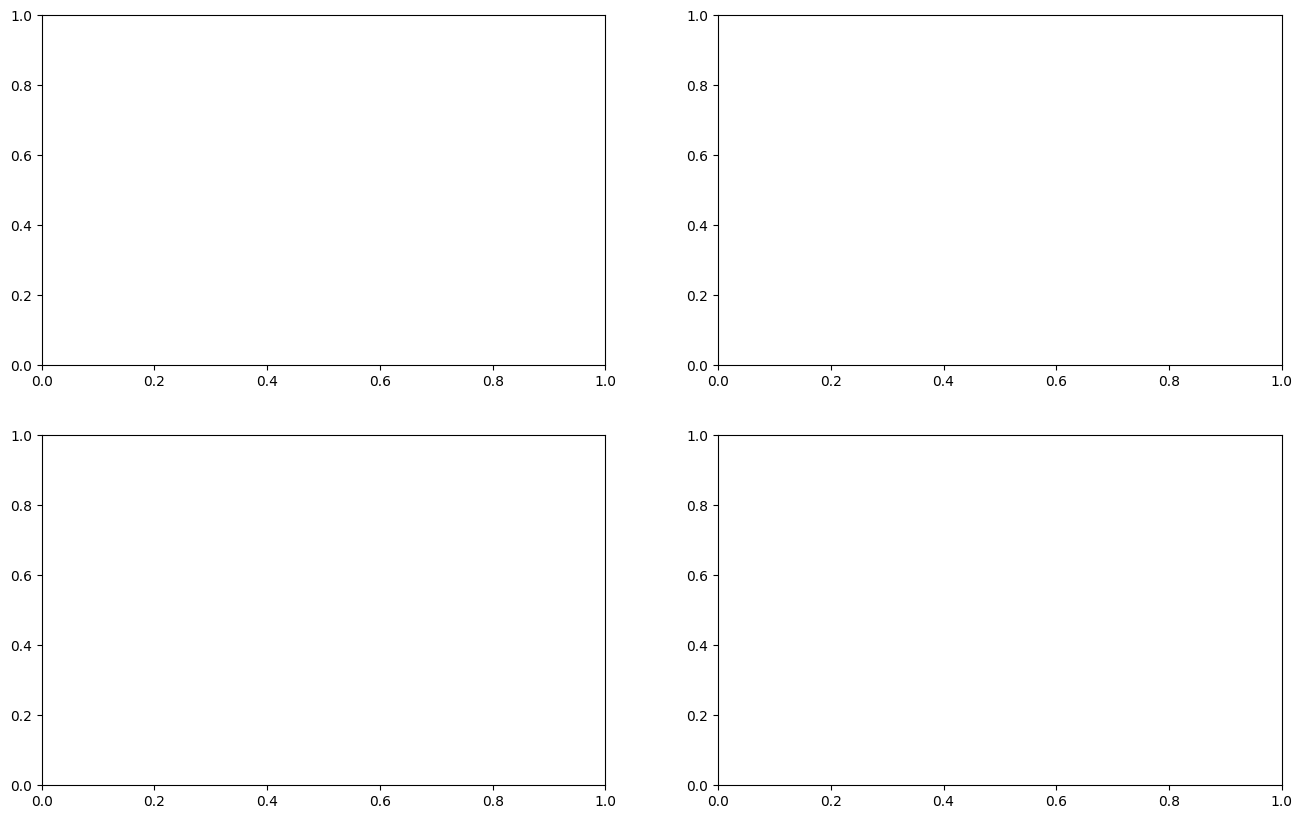

In [15]:
#@title leaf_f_phen
td_daily = [td for td, hr in zip(td, hrs_data) if hr == 0]

@interact_plus_reset(
  t_sgs = widgets.FloatSlider(min=1, max=2000, value=200, step=1), 
  t_egs = widgets.FloatSlider(min=1, max=6000, value=1995, step=1),
#   tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
#   tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
#   tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
)
def get_t_l(
    t_sgs,t_egs,
    # tt_emr, tt_veg, tt_rep,
):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
    (
        SGS,
        EGS,
        Astart,
        mid_anthesis,
        fphen_a,
        fphen_b,
        fphen_c,
        fphen_d,
        dd_emr,
        dd_veg,
        dd_rep,
        t_Astart,
        t_mid_anthesis,
        t_f_phen_a,
        t_f_phen_b,
        t_f_phen_c,
        t_f_phen_d,
        tt_emr,
        tt_veg,
        tt_rep,
    ) = get_canopy_td_intervals(
        td,
        dd_data,
        t_sgs=t_sgs,
        t_egs=t_egs,
    )

    f_phen_data = tt_f_phen_simple_PLF_range(
        td,
        t_f_phen_a,
        t_f_phen_b,
        t_f_phen_c,
        t_f_phen_d,
        f_phen_min=0.2,
        td_at_sgs=t_sgs,
    )

    (
        SGS,
        EGS,
        Astart,
        mid_anthesis,
        fphen_1_ets,
        fphen_3_ets,
        fphen_4_ets,
        fphen_5_ets,
        t_Astart,
        t_mid_anthesis,
        t_fphen_1_ets,
        t_fphen_3_ets,
        t_fphen_4_ets,
        t_fphen_5_ets,
        t_lem,
        t_lse,
        t_lma,
        t_lep,
        lem,
        lse,
        lma,
        lep,
    ) = get_leaf_td_intervals(
        td,
        dd_data,
        t_sgs=t_sgs,
        t_egs=t_egs,
    )

    t_leaf_f_phen_a = 0.3
    t_leaf_f_phen_b = 0.7
    t_leaf_f_phen_e = t_fphen_1_ets
    t_leaf_f_phen_g = t_fphen_3_ets
    t_leaf_f_phen_h = t_fphen_4_ets
    t_leaf_f_phen_i = t_fphen_5_ets
    t_astart = t_Astart
    td_at_sgs = t_sgs

    leaf_f_phen_data = tt_leaf_f_phen_PLF_range(
        td,
        t_leaf_f_phen_a,
        t_leaf_f_phen_b,
        t_leaf_f_phen_e,
        t_leaf_f_phen_g,
        t_leaf_f_phen_h,
        t_leaf_f_phen_i,
        t_astart,
        td_at_sgs,
    )

    # ===== PLOTS ===== #
    # Leaf f phen
    # Plot thermal time
    plot_leaf_f_phen_data(
        td,
        leaf_f_phen_data,
        t_leaf_f_phen_a,
        t_leaf_f_phen_b,
        t_leaf_f_phen_e,
        t_leaf_f_phen_g,
        t_leaf_f_phen_h,
        t_leaf_f_phen_i,
        t_astart,
        t_sgs,
        t_egs,
        ax=axs[0][0],
        ax_box=axs[1][0],
    )

    # Plot days
    plot_leaf_f_phen_data(
        dd_data,
        leaf_f_phen_data,
        t_leaf_f_phen_a,
        t_leaf_f_phen_b,
        fphen_1_ets,
        fphen_3_ets,
        fphen_4_ets,
        fphen_5_ets,
        Astart,
        SGS,
        EGS,
        ax=axs[0][1],
        ax_box=axs[1][1],
    )

    # f phen
    plot_f_phen_data(
        td,
        f_phen_data,
        t_sgs,
        t_egs,
        t_f_phen_a,
        t_f_phen_b,
        t_f_phen_c,
        t_f_phen_d,
        ax=axs[0][0],
        ax_box=axs[1][0],
        box_y_start=10,
    )

    plot_f_phen_data(
        dd_data,
        f_phen_data,
        SGS,
        EGS,
        fphen_a - SGS,
        fphen_b - SGS,
        fphen_c - SGS,
        fphen_d - SGS,
        ax=axs[0][1],
        ax_box=axs[1][1],
        box_y_start=10,
    )

    # Plot fla fls
    td_dd_list = [t - t_sgs for t in td]
    f_LA = [max(0, min(1, 1 - (td_dd - t_astart) / (t_lma))) for td_dd in td_dd_list]
    # f_LA = [max(0,min(1,1 - (td_dd - t_lem) / (t_lma))) for td_dd in td_dd_list]
    fO3_l = 1
    f_LS = [max(0, min(1, 1 - ((td_dd - t_astart - t_lep) / (t_lma / fO3_l - t_lep))))
            for td_dd in td_dd_list]
    # f_LS = [max(0,min(1,1 - ((td_dd - t_lem - t_lep) / (t_lma / fO3_l - t_lep)))) for td_dd in td_dd_list]
    t_l = t_lma + t_lem

    plot_ewert_phenology_data(
        td,
        f_LA,
        f_LS,
        t_lem,
        t_lma,
        t_lep,
        t_lse,
        t_sgs,
        t_egs,
        t_Astart,
        ax=axs[0][0],
        ax_box=axs[1][0],
        box_y_start=17,
    )
    plot_ewert_phenology_data(
        dd_data,
        f_LA,
        f_LS,
        lem,
        lma,
        lep,
        lse,
        SGS,
        EGS,
        Astart,
        ax=axs[0][1],
        ax_box=axs[1][1],
        box_y_start=17,
    )

    dvi_x = [td_at_sgs, td_at_sgs + tt_emr, td_at_sgs +
             tt_emr + tt_veg, td_at_sgs + tt_emr + tt_veg + tt_rep]
    dvi_y = [-1, 0, 1, 2]

    axs[0][0].plot(dvi_x, dvi_y, label="DVI", color="yellow")

    # Setup axes
    axs[0][0].set_xlim((t_sgs - 100, t_egs + 300))
    axs[1][0].set_xlim((t_sgs - 100, t_egs + 300))
    axs[0][0].set_xlabel("thermal time")
    axs[0][0].set_ylabel("leaf_f_phen")
    axs[0][0].legend()

    axs[0][1].set_xlim(((SGS - 10), (EGS + 10)))
    axs[1][1].set_xlim(((SGS - 10), (EGS + 10)))

    axs[0][1].set_xlabel("days")
    axs[0][1].set_ylabel("leaf_f_phen")
    axs[0][1].legend()
    # plt.show()

In [1]:
from do3se_phenology.config import ModelConfig, SpeciesConfig, PhenologyMethods, PhenologyKeyLengths, PhenologyKeyDates,SpeciesPresets
from do3se_phenology.switchboard import process_phenology_config

model_config = ModelConfig(
    phenology_method=PhenologyMethods.SEASON_FRACTION,
)
# species_config = replace(
#     deepcopy(example_species),
# )
species_config = SpeciesConfig(PRESET=SpeciesPresets.WHEAT_SPRING)
species_config.key_dates.sowing = 20
species_config.key_lengths_td.sowing_to_end = 2000

process_phenology_config(
        model_config=model_config,
        species_config=species_config,
        external_data=None,
        td_base_temperature=0,
    )

Using preset: SpeciesPresets.WHEAT_SPRING
Phenology: Using season fraction


(ModelConfig(flag_leaf_only=False, phenology_method=<PhenologyMethods.SEASON_FRACTION: 'season_fraction'>, dvi_method=<DVIMethods.DISABLED: 'disabled'>, LAI_method=<LAIMethods.ESTIMATE_TOTAL: 'estimate total'>, time_type=<TimeTypes.THERMAL_TIME: 'thermal_time'>, sgs_time_type=<TimeTypes.JULIAN_DAY: 'julian_day'>, sgs_key_day=<KeyDays.SOWING_DAY: 'sowing_day'>, zero_day=<ZeroDayOptions.SOWING: 'sowing'>, plant_emerge_method=<PlantEmergeMethod.CONSTANT: 'constant'>, flag_leaf_emerge_method=<PlantEmergeMethod.CONSTANT: 'constant'>, use_vernalisation=False, use_photoperiod_factor=False, sowing_day_method=<SowingDateMethods.INPUT: 'INPUT'>, latitude=None),
 SpeciesConfig(PRESET=<SpeciesPresets.WHEAT_SPRING: 'WHEAT_SPRING'>, fphen_intervals=[(0, 0), (100.0, 0), (400.0, 1), (1240.0, 1), (2000.0, 0)], leaf_fphen_intervals=[(0, 0), (1080.0, 0), (1080.0, 1), (1240.0, 1), (1340.0, 1), (1680.0, 0.7), (2000.0, 0), (2000.0, 0)], dvi_interval=[(0, -1.000000001), (100.0, 0.0), (860.0, 1.0), (2000.0, 2

In [2]:
%load_ext autoreload
%autoreload 2

from do3se_phenology.plots import plot_phenology_from_config


Using preset: SpeciesPresets.WHEAT_SPRING
Phenology: Using season fraction
SpeciesConfig(PRESET=<SpeciesPresets.WHEAT_SPRING: 'WHEAT_SPRING'>, fphen_intervals=[(0, 0), (54.1, 0), (216.4, 1), (670.84, 1), (1082.0, 0)], leaf_fphen_intervals=[(0, 0), (584.2800000000001, 0), (584.2800000000001, 1), (670.8400000000001, 1), (724.9400000000002, 1), (908.8800000000001, 0.7), (1082.0000000000002, 0), (1082.0000000000002, 0)], dvi_interval=[(0, -1.000000001), (54.1, 0.0), (465.26000000000005, 1.0), (1082.0, 2.0)], key_dates=PhenologyKeyDates(sowing=0, emergence=None, harvest=None, Astart=None, Aend=None, mid_anthesis=None), key_dates_td=PhenologyKeyDates(sowing=0, emergence=54.1, harvest=1082.0, Astart=584.2800000000001, Aend=1082.0, mid_anthesis=670.84), key_lengths=PhenologyKeyLengths(sowing_to_emerge=None, sowing_to_f_phen_b=None, sowing_to_f_phen_c=None, sowing_to_astart=None, sowing_to_end=None, emerg_to_astart=None, emerg_to_end=None, emerg_to_veg=None, veg_to_harvest=None), key_lengths_td

/home/sam/work/SEI/projects/do3se/do3se_phenology/do3se_phenology/plots.py:254: RuntimeWarning: invalid value encountered in divide
  (ff + sum(g[i + 1:])) / sum(g) if i < len(g) else (p * ff) / sum(g)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 2400x2400 with 4 Axes>,
 [[<AxesSubplot: title={'center': 'Phenology'}, xlabel='thermal time', ylabel='%'>],
  [<AxesSubplot: title={'center': 'Phenology lengths'}>],
  [<AxesSubplot: title={'center': 'Carbon distribution fractions'}>],
  [<AxesSubplot: title={'center': 'Growing populations'}>]])

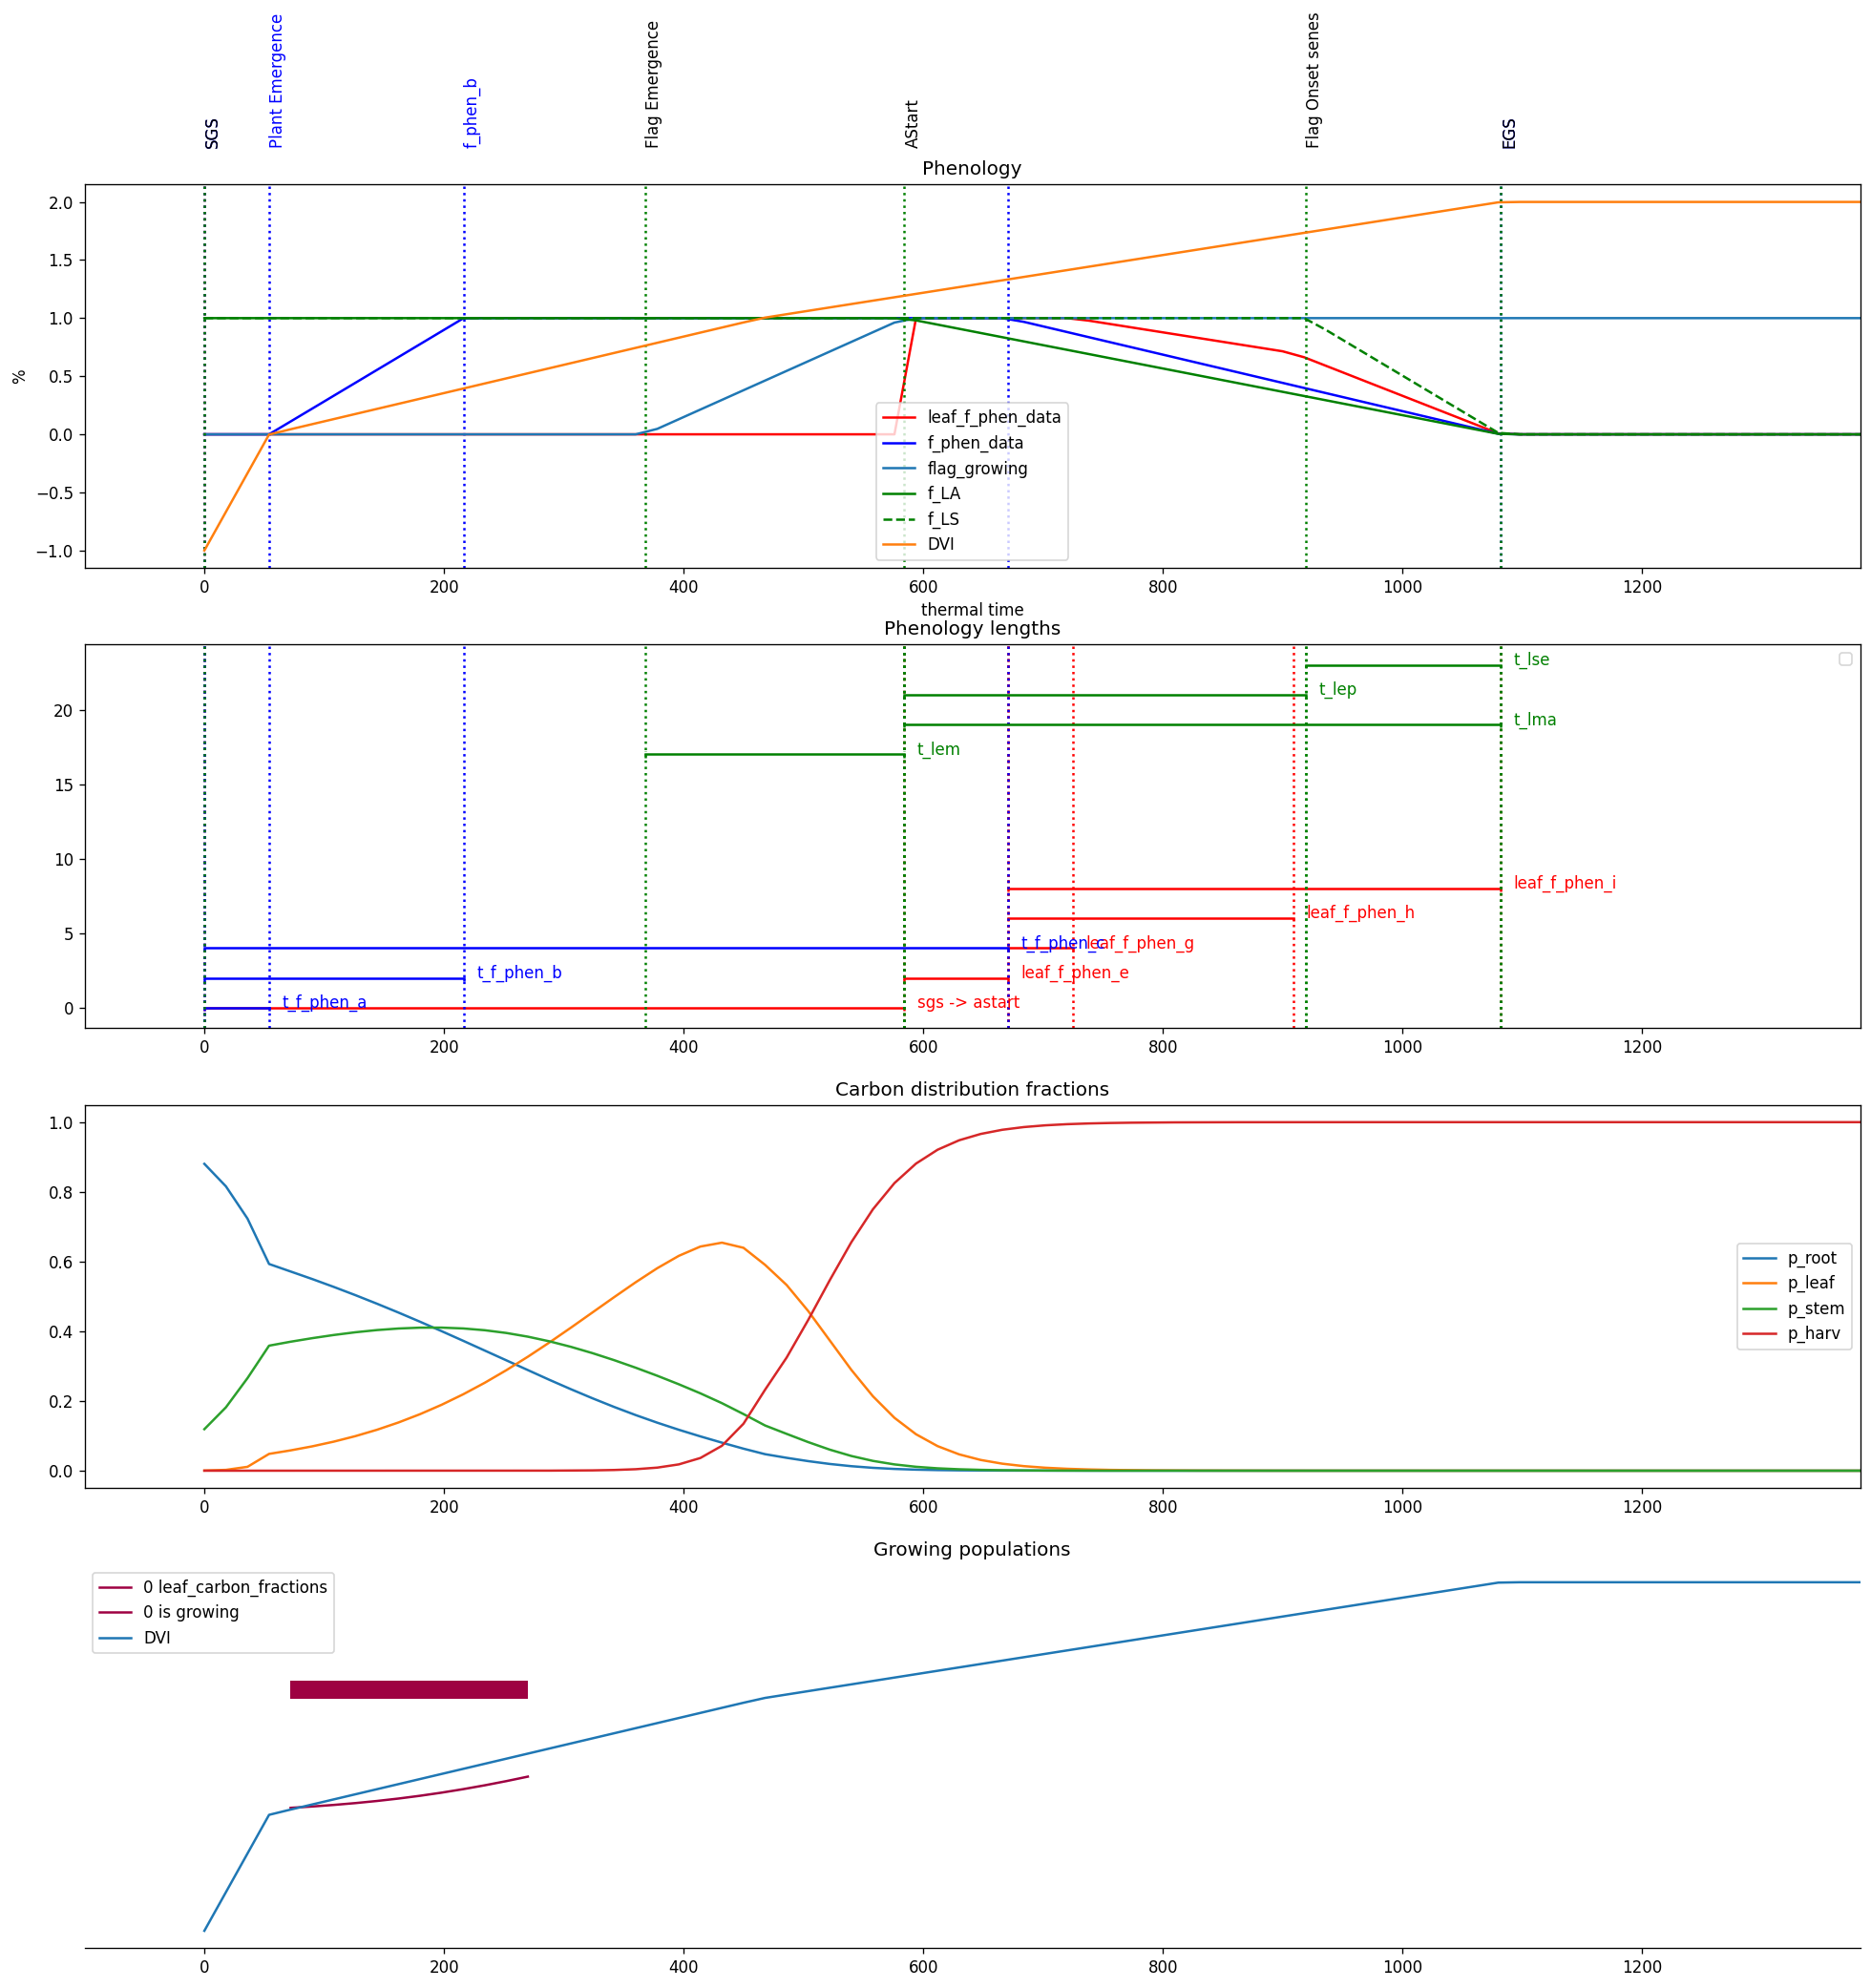

In [42]:
from do3se_phenology.config import PhenologyMethods, PhenologyKeyLengths, PhenologyKeyDates,SpeciesPresets
species_config = SpeciesConfig(
    PRESET= SpeciesPresets.WHEAT_SPRING,
    key_dates= PhenologyKeyDates(
    sowing=0,
    ),
    key_lengths_td= PhenologyKeyLengths(
        sowing_to_end= 1082,
    ),
    # SAI_method= "LAI_BROWN_GREEN",
    # day_fphen_plf= {},
    # leaf_f_phen_method= "tt day PLF",
    # f_phen_method= "tt day PLF",
    # PIV= 0.0556,
    # v_T_max= 23.8459,
    # v_T_min= 3.8413,
    # f_phen_min= 0,
    # leaf_f_phen_a= 0.3,
    # leaf_f_phen_b= 0.7,
    # f_Astart= 0.56,
    # f_mid_anthesis= 0.64,
    # f_fphen_1_ets= 0.08,
    # f_fphen_3_ets= 0.05,
    # f_fphen_4_ets= 0.22,
    # f_fphen_5_ets= 0.36,
    f_t_lem= 0.2,
    # f_t_lma= 0.49,
    # f_t_lep= 0.35,
    # f_t_lse= 0.14,
    # f_t_lse_mature= 0.33,
    # f_fphen_a= 0.05,
    # f_fphen_b= 0.2,
    # f_fphen_c= 0.64,
    # f_fphen_d= 1.0,
    # f_tt_emr= 0.05,
    # f_tt_veg= 0.38,
    # f_tt_rep= 0.57,
    # f_leaf_f_fphen= 0.44
)
    
model_config = ModelConfig(
    phenology_method=PhenologyMethods.SEASON_FRACTION,
)

model_config, species_config = process_phenology_config(model_config, species_config, None)
print(species_config)
nP = 1
plot_phenology_from_config(
    species_config,
    model_config,
    nP=nP,
)

In [45]:
#@title phenology plot
from do3se_phenology.config import PhenologyMethods, PhenologyKeyLengths, PhenologyKeyDates

@interact_plus_reset(
    PIV=widgets.FloatSlider(min=0, max=1, value= 0.0556, step=0.01),
    v_T_max=widgets.FloatSlider(min=0, max=1, value= 23.8459, step=0.01),
    v_T_min=widgets.FloatSlider(min=0, max=1, value= 3.8413, step=0.01),
    f_phen_min=widgets.FloatSlider(min=0, max=1, value= 0, step=0.01),
    leaf_f_phen_a=widgets.FloatSlider(min=0, max=1, value= 0.3, step=0.01),
    leaf_f_phen_b=widgets.FloatSlider(min=0, max=1, value= 0.7, step=0.01),
    f_Astart=widgets.FloatSlider(min=0, max=1, value= 0.56, step=0.01),
    f_mid_anthesis=widgets.FloatSlider(min=0, max=1, value= 0.62, step=0.01),
    f_fphen_1_ets=widgets.FloatSlider(min=0, max=1, value= 0.08, step=0.01),
    f_fphen_3_ets=widgets.FloatSlider(min=0, max=1, value= 0.05, step=0.01),
    f_fphen_4_ets=widgets.FloatSlider(min=0, max=1, value= 0.22, step=0.01),
    f_fphen_5_ets=widgets.FloatSlider(min=0, max=1, value= 0.36, step=0.01),
    f_t_lem=widgets.FloatSlider(min=0, max=1, value= 0.14, step=0.01),
    f_t_lma=widgets.FloatSlider(min=0, max=1, value= 0.46, step=0.01),
    f_t_lep=widgets.FloatSlider(min=0, max=1, value= 0.31, step=0.01),
    f_t_lse=widgets.FloatSlider(min=0, max=1, value= 0.15, step=0.01),
    f_t_lse_mature=widgets.FloatSlider(min=0, max=1, value= 0.33, step=0.01),
    f_fphen_a=widgets.FloatSlider(min=0, max=1, value= 0.05, step=0.01),
    f_fphen_b=widgets.FloatSlider(min=0, max=1, value= 0.2, step=0.01),
    f_fphen_c=widgets.FloatSlider(min=0, max=1, value= 0.62, step=0.01),
    # f_fphen_d=widgets.FloatSlider(min=0, max=1, value= 1.0, step=0.01),
    f_tt_emr=widgets.FloatSlider(min=0, max=1, value= 0.05, step=0.01),
    f_tt_veg=widgets.FloatSlider(min=0, max=1, value= 0.38, step=0.01),
    f_tt_rep=widgets.FloatSlider(min=0, max=1, value= 0.57, step=0.01),
    f_leaf_f_fphen=widgets.FloatSlider(min=0, max=1, value= 0.44, step=0.01),
)

def get_plot(
    PIV,
    v_T_max,
    v_T_min,
    f_phen_min,
    leaf_f_phen_a,
    leaf_f_phen_b,
    f_Astart,
    f_mid_anthesis,
    f_fphen_1_ets,
    f_fphen_3_ets,
    f_fphen_4_ets,
    f_fphen_5_ets,
    f_t_lem,
    f_t_lma,
    f_t_lep,
    f_t_lse,
    f_t_lse_mature,
    f_fphen_a,
    f_fphen_b,
    f_fphen_c,
    # f_fphen_d,
    f_tt_emr,
    f_tt_veg,
    f_tt_rep,
    f_leaf_f_fphen,
):
    species_config = SpeciesConfig(
        key_dates= PhenologyKeyDates(
        sowing=0,
        ),
        key_lengths_td= PhenologyKeyLengths(
            sowing_to_end= 1082,
        ),
        SAI_method= "LAI_BROWN_GREEN",
        PRESET= "WHEAT_SPRING",
        day_fphen_plf= {},
        leaf_f_phen_method= "tt day PLF",
        f_phen_method= "tt day PLF",
        PIV=PIV,
        v_T_max=v_T_max,
        v_T_min=v_T_min,
        f_phen_min=f_phen_min,
        leaf_f_phen_a=leaf_f_phen_a,
        leaf_f_phen_b=leaf_f_phen_b,
        f_Astart=f_Astart,
        f_mid_anthesis=f_mid_anthesis,
        f_fphen_1_ets=f_fphen_1_ets,
        f_fphen_3_ets=f_fphen_3_ets,
        f_fphen_4_ets=f_fphen_4_ets,
        f_fphen_5_ets=f_fphen_5_ets,
        f_t_lem=f_t_lem,
        f_t_lma=f_t_lma,
        f_t_lep=f_t_lep,
        f_t_lse=f_t_lse,
        f_t_lse_mature=f_t_lse_mature,
        f_fphen_a=f_fphen_a,
        f_fphen_b=f_fphen_b,
        f_fphen_c=f_fphen_c,
        f_fphen_d=1.0,
        f_tt_emr=f_tt_emr,
        f_tt_veg=f_tt_veg,
        f_tt_rep=f_tt_rep,
        f_leaf_f_fphen=f_leaf_f_fphen,
    )
        
    model_config = ModelConfig(
        phenology_method=PhenologyMethods.SEASON_FRACTION,
    )
        
    nP = 1
    plot_phenology_from_config(
        species_config,
        model_config,
        nP=nP,
    )

Button(description='Reset', style=ButtonStyle())

Output()